# Template for Spectral and temporal modifications Lab


*From R. Badeau and G. Richard (with help from P. Vernhet); MAJ:2019,2024*

**python version >=3.6**

In [2198]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from copy import deepcopy
from math import ceil
import soundfile as sf
import scipy as sp

## Functions

In [2199]:
def plot_sound(data, times, name="default_name", save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    if save:
        plt.savefig(name + ".png", dpi=100)
    plt.show()


def nextpow2(x):
    assert x > 0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2 ** (p - 1) < x <= x_
    return x_


def period(x, Fs, Pmin=1 / 300, Pmax=1 / 80, seuil=0.7):
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin * Fs).astype(int)
    Nmax = 1 + np.floor(Pmax * Fs).astype(int)
    Nmax = np.min([Nmax, N])

    Nfft = nextpow2(2 * N - 1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I + Nmin
    corr = (rmax / r[0]) * (N / (N - P))
    voiced = corr > seuil
    if not (voiced):
        P = np.round(10e-3 * Fs)

    return P, voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in the same directory as the notebook.

In [2200]:
filename = 'aeiou.wav'
file_path = os.path.join(os.getcwd(), filename) 

### **Using Soundfile**

In [2201]:
x, Fs= sf.read(file_path)

In [2202]:
IPython.display.Audio(file_path)

In [2203]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

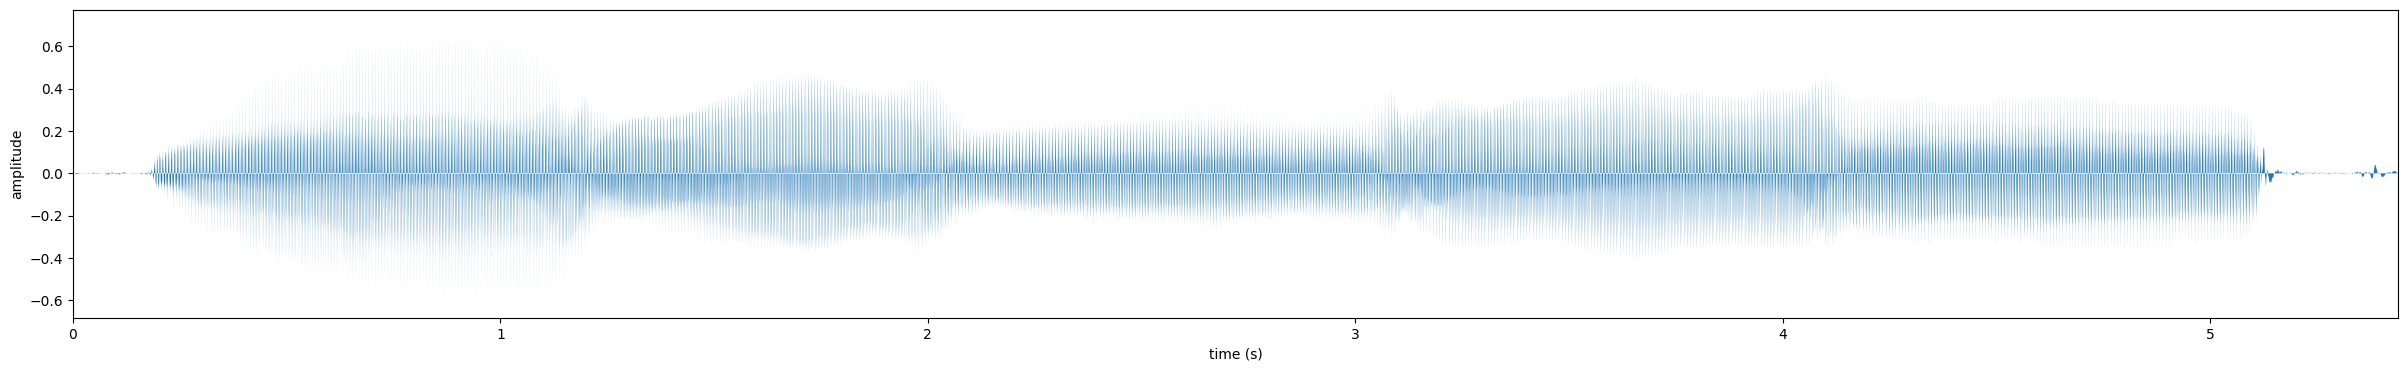

In [2204]:
plot_sound(x, times)

In [2205]:
sf.write('new_aeiou.wav',x, samplerate=Fs) # to write a new wave file

In [2206]:
def AnalysisPitchMark(signal, Fs):
    
    n = len(signal)
    A = np.zeros((3, n))
    index = 1
    Pa = 0.1 * Fs
    ta = 0
    A[0, 0] = ta
    A[2, 0] = Pa
    

    while int(ta + 2.5 * Pa) <= n:
        ta = A[0, index - 1]
        Pa = A[2, index - 1]

        start = int(ta)
        end = int(ta + 2.5 * Pa)

        signal_segment = signal[start : end]

        Pa, voiced = period(signal_segment, Fs)
        A[1, index] = voiced
        A[2, index] = Pa
        ta = ta + Pa
        A[0, index] = ta

        index += 1

    return A[:, :index]

In [2207]:
A = AnalysisPitchMark(x, Fs)
print(f"The A matrix is:\n {A}")

The A matrix is:
 [[0.0000e+00 7.8000e+01 1.8800e+02 ... 5.9471e+04 5.9581e+04 5.9691e+04]
 [0.0000e+00 1.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.1025e+03 7.8000e+01 1.1000e+02 ... 1.1000e+02 1.1000e+02 1.1000e+02]]


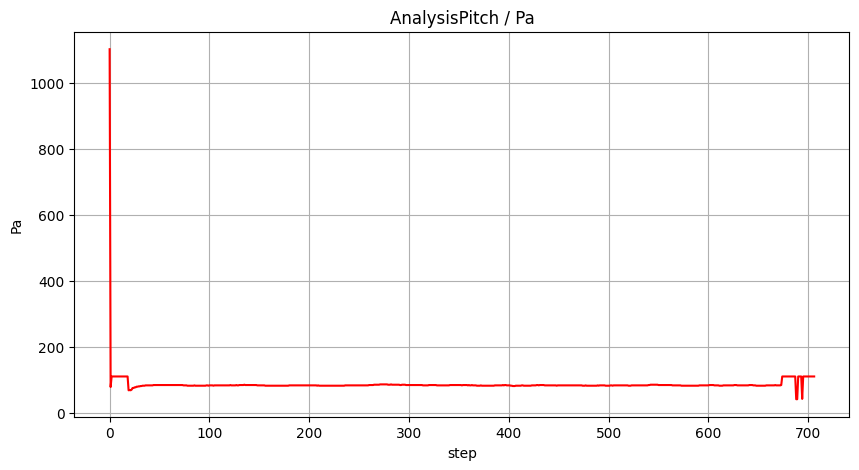

In [2208]:
plt.figure(figsize=(10, 5))
plt.plot(A[2, :], color='red')
plt.grid()
plt.xlabel("step")
plt.ylabel("Pa")
plt.title("AnalysisPitch / Pa")
plt.show()

In [2209]:
B = np.zeros((2, A.shape[1]))     
B[0, :] = A[0, :]
B[1, :] = np.arange(1, A.shape[1] + 1)

In [2210]:
def Synthesis(s, Fs, A, B):
    
    nk_end = int(B[1, -1])
    y = np.zeros(int(B[0, -1] + A[2, nk_end - 1]))
    
    for k in range(B.shape[1]):

        n_k = int(B[1, k])

        if n_k >= A.shape[1]:  
            continue
        
        ts = B[0, k]
        ta = A[0, n_k] 
        Pa = A[2, n_k]
        
        start_ta = max(0, int(ta - Pa))
        end_ta = min(len(s), int(ta + Pa))
        
        start_ts = max(0, int(ts - Pa))
        end_ts = min(len(y), int(ts + Pa))
        
        x_inter = s[start_ta: end_ta]
        length_min = min(len(x_inter), end_ts - start_ts)

        x_inter = x_inter[: length_min]
        
        w = sp.signal.windows.hann(length_min)
        x_inter *= w

        
        y[start_ts: start_ts + length_min] += x_inter
    
    return y

In [2211]:
y = Synthesis(x, Fs, A, B)
sf.write('synthesis.wav',y , samplerate=Fs)

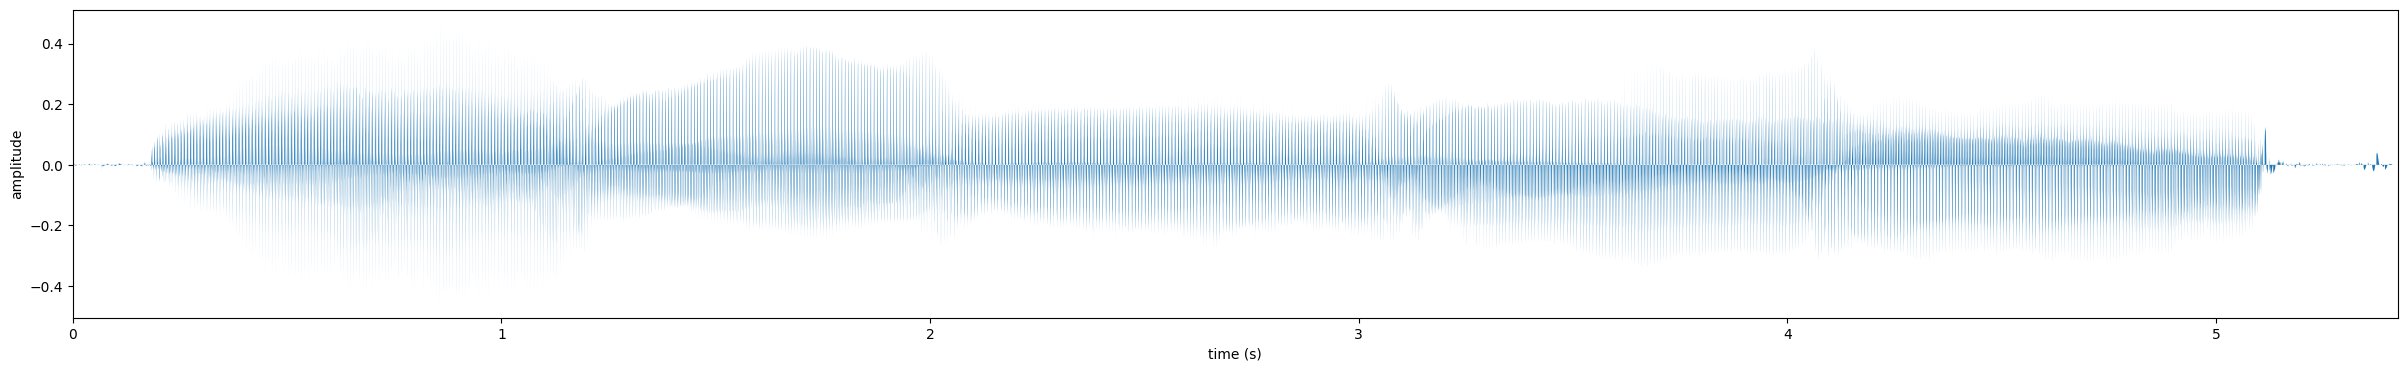

In [2212]:
times =  np.arange(len(y))*timestep
plot_sound(y, times)

In [2213]:
filename = 'synthesis.wav'
file_path = os.path.join(os.getcwd(), filename)
IPython.display.Audio(file_path) 

In [2214]:
def ChangeTimeScale(alpha, A, Fs = Fs):
    
    n = 1
    B = [[0, 0]]
    ts = 0

    while int(n) < A.shape[1] - 1:

        ts = ts + A[2, int(round(n))]
        B.append([int(round(ts)), int(round(n))])
        n += 1 / alpha

    B = np.array(B).T
    return B

In [2215]:
B_2 = ChangeTimeScale(1/2, A, Fs)
print(f"The synthesised B is:\n {B_2}")

The synthesised B is:
 [[    0    78   188   298   408   518   628   738   848   958  1026  1094
   1169  1246  1325  1405  1486  1568  1650  1733  1816  1899  1982  2066
   2150  2234  2318  2402  2486  2570  2654  2738  2822  2906  2990  3074
   3158  3242  3325  3408  3490  3572  3654  3737  3819  3901  3983  4065
   4147  4230  4312  4395  4478  4561  4644  4727  4810  4893  4976  5059
   5142  5226  5309  5392  5476  5559  5643  5727  5812  5896  5980  6064
   6148  6232  6316  6399  6482  6565  6648  6730  6812  6894  6976  7058
   7140  7222  7304  7386  7468  7550  7632  7715  7798  7881  7964  8047
   8130  8213  8296  8379  8462  8545  8628  8711  8794  8877  8959  9041
   9123  9205  9287  9369  9451  9533  9615  9697  9779  9861  9943 10026
  10109 10192 10275 10358 10441 10524 10607 10690 10773 10856 10939 11023
  11107 11192 11277 11362 11448 11534 11620 11706 11791 11876 11961 12046
  12131 12216 12300 12385 12470 12554 12638 12722 12806 12890 12974 13058
  13142 13226 1

In [2216]:
y_2 = Synthesis(x, Fs, A, B_2)
sf.write('synthesis_2.wav',y_2 ,samplerate=Fs)

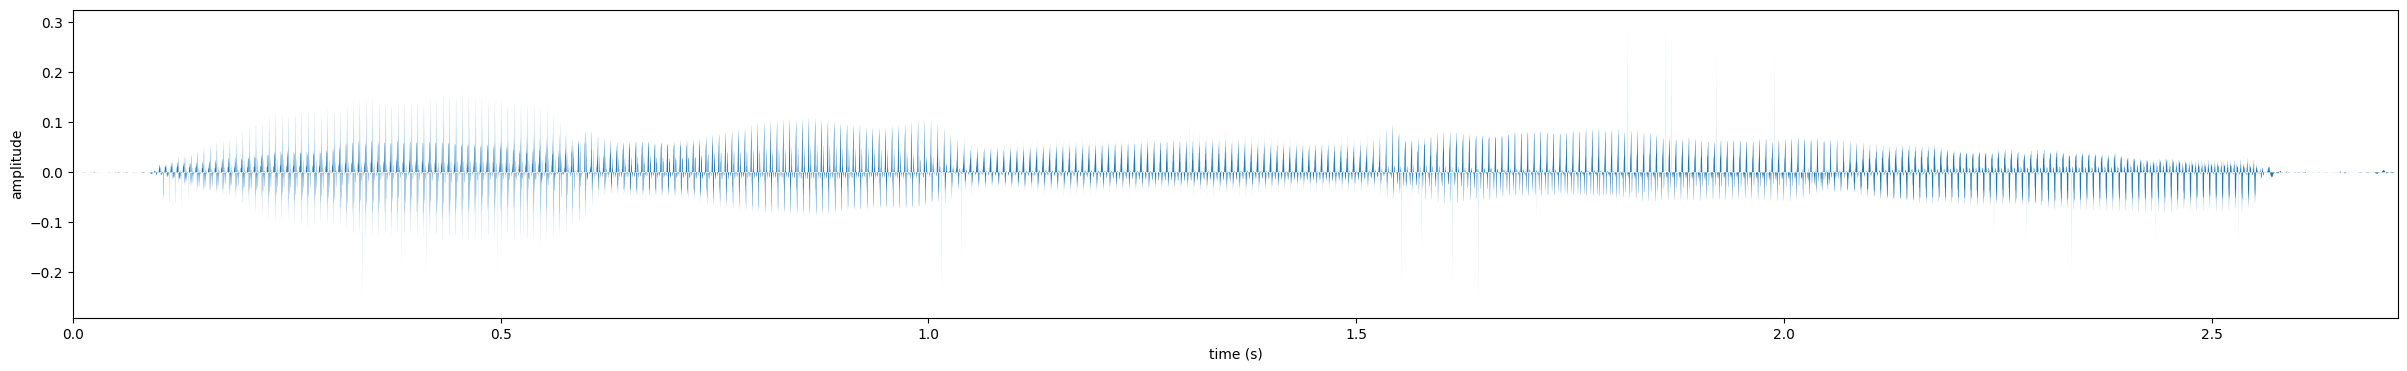

In [2217]:
times =  np.arange(len(y_2))*timestep
plot_sound(y_2, times)

In [2218]:
filename = 'synthesis_2.wav'
file_path = os.path.join(os.getcwd(), filename)
IPython.display.Audio(file_path) 

In [2219]:
def ChangePitchScale(beta,A,Fs):
    
    B = [[0, 0]]
    n = 1
    ts = 0

    while int(n) < A.shape[1] - 1:

        scale = (1/beta) if A[1, int(round(n))] == 1 else 1
        ts = ts + scale * A[2, int(n)]
        B.append([int(round(ts)), int(round(n))])
        n += scale

    B = np.array(B).T
    
    return B

In [2220]:
B_3 = ChangePitchScale(0.5, A, Fs)
print(f"The synthesised B is:\n {B_3}")

The synthesised B is:
 [[    0   156   266   376   486   596   706   816   926  1036  1146  1256
   1366  1476  1586  1696  1806  1916  2052  2188  2338  2492  2650  2810
   2972  3136  3300  3466  3632  3798  3964  4132  4300  4468  4636  4804
   4972  5140  5308  5476  5644  5812  5980  6148  6316  6484  6650  6816
   6980  7144  7308  7474  7638  7802  7966  8130  8294  8460  8624  8790
   8956  9122  9288  9454  9620  9786  9952 10118 10284 10452 10618 10784
  10952 11118 11286 11454 11624 11792 11960 12128 12296 12464 12632 12798
  12964 13130 13296 13460 13624 13788 13952 14116 14280 14444 14608 14772
  14936 15100 15264 15430 15596 15762 15928 16094 16260 16426 16592 16758
  16924 17090 17256 17422 17588 17754 17918 18082 18246 18410 18574 18738
  18902 19066 19230 19394 19558 19722 19886 20052 20218 20384 20550 20716
  20882 21048 21214 21380 21546 21712 21878 22046 22214 22384 22554 22724
  22896 23068 23240 23412 23582 23752 23922 24092 24262 24432 24600 24770
  24940 25108 2

In [2221]:
y_3 = Synthesis(x, Fs, A, B_3)
sf.write('synthesis_3.wav',y_3 , samplerate=Fs)

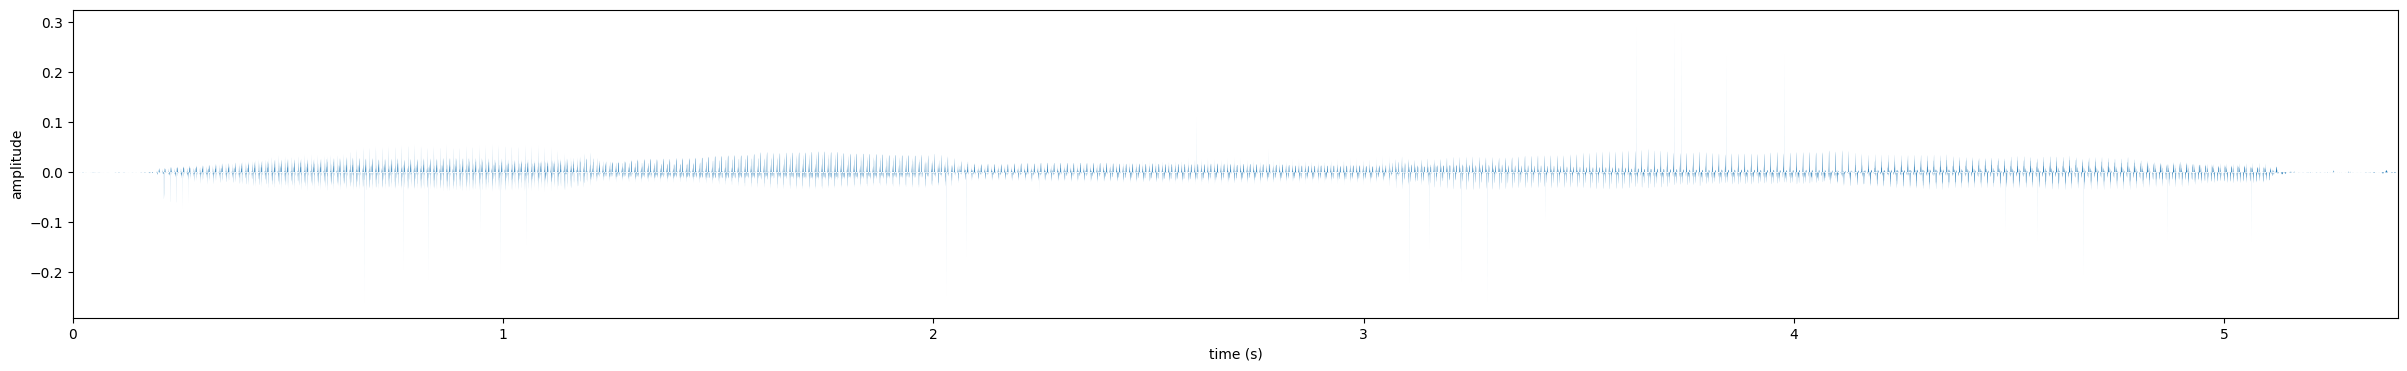

In [2222]:
times =  np.arange(len(y_3))*timestep
plot_sound(y_3, times)

In [2223]:
filename = 'synthesis_3.wav'
file_path = os.path.join(os.getcwd(), filename)
IPython.display.Audio(file_path) 

In [2224]:
def ChangeBothScales(alpha, beta, A, Fs):
    
    B = [[0, 0]]  
    ts = 0      
    n = 0      

    while n < A.shape[1] - 1:  

        
        scale = (1 / beta) if A[1, int(round(n))] == 1 else 1
        ts += scale * A[2, int(round(n))]
        
        
        B.append([int(round(ts)), int(round(n))])
        
        
        n += 1 / alpha

    return np.array(B).T

In [2225]:
B_final = ChangeBothScales(1/2, 2, A, Fs)
print(f"The synthesised B is:\n {B_final}")

The synthesised B is:
 [[    0  1102  1212  1322  1432  1542  1652  1762  1872  1982  2092  2127
   2162  2200  2238  2278  2318  2358  2399  2440  2482  2524  2565  2607
   2649  2691  2733  2775  2817  2859  2901  2943  2985  3027  3069  3111
   3153  3195  3236  3278  3319  3360  3401  3442  3483  3524  3565  3606
   3647  3688  3730  3771  3812  3854  3895  3936  3978  4020  4061  4102
   4144  4186  4227  4268  4310  4352  4394  4436  4478  4520  4562  4604
   4646  4688  4730  4771  4812  4854  4896  4936  4978  5018  5060  5100
   5142  5182  5224  5264  5306  5346  5388  5429  5470  5512  5554  5595
   5636  5678  5720  5761  5802  5844  5886  5927  5968  6010  6050  6092
   6132  6174  6214  6256  6296  6338  6378  6420  6460  6502  6542  6584
   6626  6667  6708  6750  6792  6833  6874  6916  6958  6999  7040  7082
   7124  7166  7209  7252  7294  7337  7380  7423  7466  7508  7552  7594
   7636  7679  7722  7764  7806  7848  7890  7932  7974  8016  8058  8100
   8142  8184  

In [2226]:
y_4 = Synthesis(x, Fs, A, B_final)
sf.write('synthesis_4.wav',y_4 , samplerate=Fs)

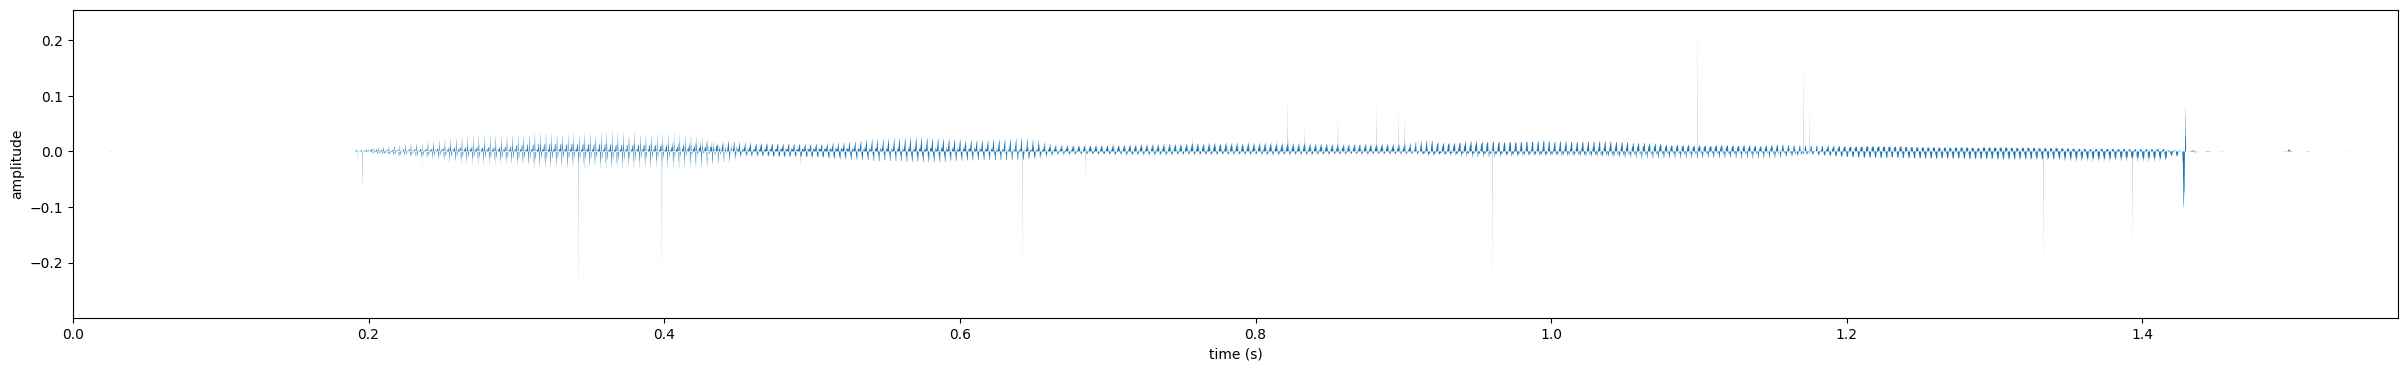

In [2227]:
times =  np.arange(len(y_4))*timestep
plot_sound(y_4, times)

In [2228]:
filename = 'synthesis_4.wav'
file_path = os.path.join(os.getcwd(), filename)
IPython.display.Audio(file_path) 